In [2]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns  
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from sklearn.ensemble import IsolationForest
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.svm import OneClassSVM
from keras.models import Model
from keras.layers import Input, Dense, LeakyReLU, BatchNormalization
from keras.models import Model, Sequential
from keras.optimizers import Adam
from sklearn.metrics import roc_curve, auc
from sklearn.manifold import TSNE
%matplotlib inline  
plt.style.use('fivethirtyeight') 

In [3]:
file_path = 'merged_data.csv'
data = pd.read_csv(file_path)

## Risk Event Model

In [4]:
data['cluster_anomaly'] = 0
data['anomaly_score'] = 0
data['at_risk_event'] = data['at_risk_event'].astype(int)

In [5]:
data

,individual_id,timestamp,date,day_of_week,hour_of_day,department,spend,at_risk_event,at_risk_behaviour_window,log_spend,...,moving_average,moving_average_diff,moving_std,dept_mean_spend,dept_std_spend,high_spend,is_first_high_spend,cluster_y,cluster_anomaly,anomaly_score
0,1,59:40.0,2023-01-09,Monday,11.994438,ops,1.131402,0,NaN,1.131402,...,-1.010767,-0.000016,-1.724579,1.972583,1.096185,0,0,0,0,0
1,1,10:02.9,2023-01-11,Wednesday,9.167461,ops,1.695616,0,NaN,1.695616,...,-0.618265,0.667351,-0.768913,1.972583,1.096185,0,0,0,0,0
2,1,51:48.7,2023-01-12,Thursday,8.863522,ops,1.597365,0,NaN,1.597365,...,-0.532997,0.144964,-1.002567,1.972583,1.096185,0,0,0,0,0
3,1,44:15.0,2023-01-12,Thursday,10.737514,ops,1.313724,0,NaN,1.313724,...,-0.448441,0.143754,-1.249562,1.972583,1.096185,0,0,0,0,0
4,1,30:58.9,2023-01-12,Thursday,13.516375,ops,0.916291,0,NaN,0.916291,...,-0.809872,-0.614554,-0.905071,1.972583,1.096185,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
105272,2184,20:57.3,2023-04-20,Thursday,12.349245,finance,2.293544,0,NaN,2.293544,...,-0.747568,-0.875034,0.398207,1.861596,0.994449,0,0,1,0,0
105273,2184,12:27.8,2023-04-21,Friday,10.207728,finance,3.055886,0,NaN,3.055886,...,0.410140,1.968423,0.625967,1.861596,0.994449,0,0,1,0,0
105274,2184,24:52.3,2023-04-24,Monday,17.414535,finance,2.583998,0,NaN,2.583998,...,1.094409,1.163441,-0.802944,1.861596,0.994449,0,0,1,0,0
105275,2185,50:15.0,2023-02-08,Wednesday,12.837514,investor_relations,2.814210,0,NaN,2.814210,...,1.330565,0.401517,-1.724579,1.923708,1.044406,0,0,0,0,0


In [6]:
# iso_forest
clusters = data['cluster_y'].unique()
for cluster in clusters:
    cluster_indices = data[data['cluster_y'] == cluster].index
    cluster_features = data.loc[cluster_indices, [
        'moving_average', 'moving_std', 'moving_average_diff',  'is_first_weekend_tx', 'is_first_non_working_tx', 'high_spend'
    ]]
    contamination_estimate = min(0.5, max(2 * len(cluster_features[cluster_features['high_spend'] == 1]) / len(cluster_features), 0.01))
    iso_forest_cluster = IsolationForest(n_estimators=1000, contamination=contamination_estimate, random_state=3)
    iso_forest_cluster.fit(cluster_features)

    anomalies = iso_forest_cluster.predict(cluster_features)
    data.loc[cluster_indices, 'cluster_anomaly'] = [1 if x == -1 else 0 for x in anomalies]
    data.loc[cluster_indices, 'anomaly_score'] = iso_forest_cluster.decision_function(cluster_features)

cm = confusion_matrix(data['at_risk_event'], data['cluster_anomaly'])
tn, fp, fn, tp = cm.ravel()
precision = tp / (tp + fp)
recall = tp / (tp + fn)
f1_score = 2 * (precision * recall) / (precision + recall)
accuracy = (tp + tn) / (tp + tn + fp + fn)
print(f"Precision: {precision:.2f}")
print(f"Accuracy: {accuracy:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1_score:.2f}")

D:\Anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
D:\Anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
D:\Anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


Precision: 0.17
Accuracy: 0.90
Recall: 0.71
F1 Score: 0.28


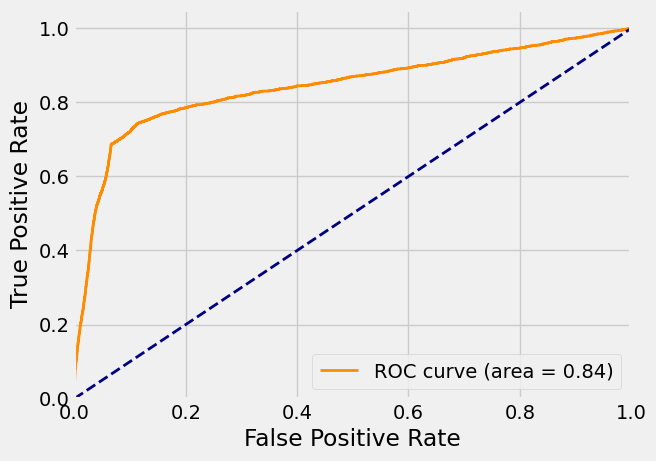

In [7]:
# Compute ROC curve and AUC
fpr, tpr, thresholds = roc_curve(data['at_risk_event'], -data['anomaly_score'])
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.show()

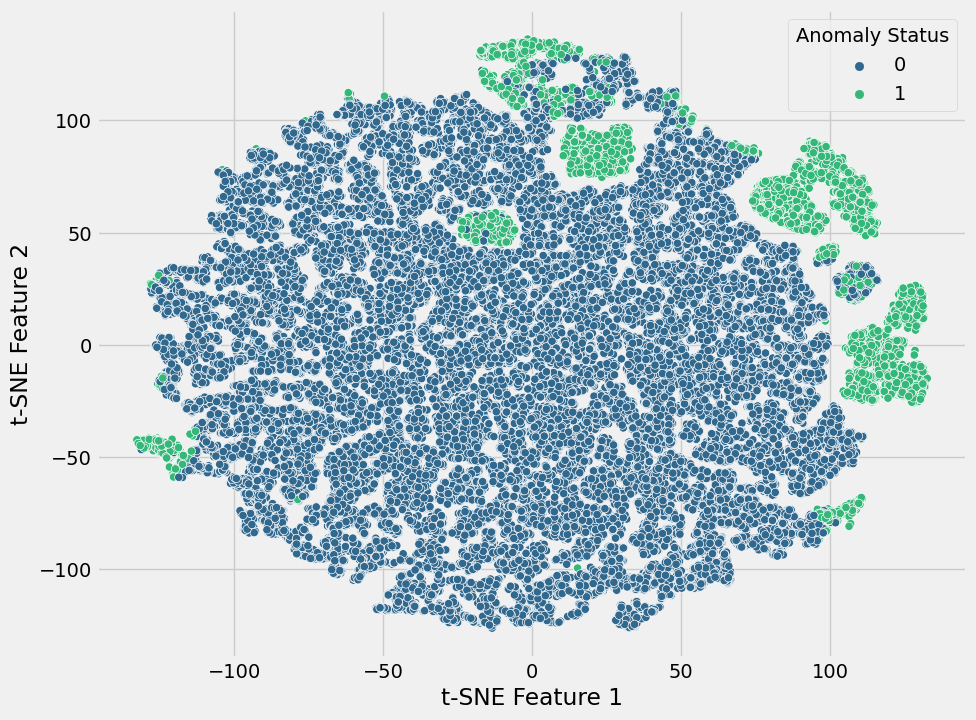

In [8]:
# t-SNE 
tsne = TSNE(n_components=2, random_state=3)
features = data[['moving_average', 'moving_std', 'moving_average_diff', 'is_first_weekend_tx', 'is_first_non_working_tx', 'high_spend']]
tsne_results = tsne.fit_transform(features)
plt.figure(figsize=(10, 8))
sns.scatterplot(x=tsne_results[:, 0], y=tsne_results[:, 1], hue=data['cluster_anomaly'], palette='viridis', legend='full')
plt.xlabel('t-SNE Feature 1')  # Abscissa heading
plt.ylabel('t-SNE Feature 2')  # Ordinate heading
plt.legend(title='Anomaly Status')
plt.show()

In [ ]:
# correct the timestamp
data['hours'] = data['hour_of_day'].apply(lambda x: int(x))
data['minutes_seconds'] = data['timestamp'].str.split('.').str[0]  # Remove the decimal point after seconds
data['minutes_seconds'] = pd.to_datetime(data['minutes_seconds'], format='%M:%S').dt.time
data['date'] = pd.to_datetime(data['date'], format='%Y-%m-%d')
data['time'] = data.apply(lambda row: pd.Timestamp.combine(row['date'], row['minutes_seconds']) + pd.Timedelta(hours=row['hours']), axis=1)
print(data[['date', 'hours', 'minutes_seconds', 'time']])

In [ ]:
data['frequent_non_working_time_work'] = ((data['non_working_time'] == 1) & (data['is_first_non_working_tx'] == 0)).astype(int)
data['frequent_weekend_work'] = ((data['is_weekend'] == 1) & (data['is_first_weekend_tx'] == 0)).astype(int)
data['frequent_high_spend'] = ((data['high_spend'] == 1) & (data['is_first_high_spend'] == 0)).astype(int)

In [ ]:
data

In [ ]:
data.to_csv('datag.csv',index=False)

In [ ]:
file_path = 'datag.csv'
data = pd.read_csv(file_path)

## Risk Window Model

In [ ]:
# ISO Model Q2
data['second_target_pred'] = False 
data['anomaly_score'] = 0

data['time'] = pd.to_datetime(data['time'], format='%Y-%m-%d %H:%M:%S')

clusters = data['cluster_y'].unique()


for cluster in clusters:
    cluster_indices = data[data['cluster_y'] == cluster].index
    cluster_features = data.loc[cluster_indices, [
        'moving_average', 'moving_std', 'moving_average_diff', 'frequent_non_working_time_work', 'frequent_weekend_work', 'frequent_high_spend'
    ]]
    
    #contamination_estimate
    risk_indicators = ['frequent_non_working_time_work', 'frequent_weekend_work', 'frequent_high_spend']
    contamination_components = [cluster_features[feature] == 1 for feature in risk_indicators]
    contamination_rate = sum(contamination_components) / len(contamination_components)
    contamination_estimate = min(0.5, max(3 * contamination_rate.mean(), 0.01))
    
    iso_forest_cluster = IsolationForest(n_estimators=1000, contamination=contamination_estimate, random_state=3)
    iso_forest_cluster.fit(cluster_features)

    anomalies = iso_forest_cluster.predict(cluster_features)
    anomaly_indices = cluster_indices[anomalies == -1]

    # mark anomalies and all transactions within the subsequent five days
    for idx in anomaly_indices:
        individual_id = data.at[idx, 'individual_id']
        anomaly_time = data.at[idx, 'time']
        window_start = anomaly_time
        window_end = anomaly_time + pd.Timedelta(days=5)
        window_indices = data[(data['individual_id'] == individual_id) & (data['time'] >= window_start) & (data['time'] <= window_end)].index
        data.loc[window_indices, 'second_target_pred'] = True
        valid_indices = cluster_features.index.intersection(window_indices)
        data.loc[valid_indices, 'anomaly_score'] = -iso_forest_cluster.decision_function(cluster_features.loc[valid_indices])

In [ ]:
data.to_csv('datag2.csv',index=False)
df = pd.read_csv("datag2.csv", index_col=0)
df

In [ ]:
df.reset_index(drop=True, inplace=True)
def second_target_eval_func(df,
                            second_target_pred_col_name="second_target_pred",
                            at_risk_behaviour_window_col_name="at_risk_behaviour_window"):
    """
    Evaluate the predictions for the second target, at_risk_behaviour_window.

    Args:
        df (pandas.DataFrame): the dataframe with your predictions and the target window.
        second_target_pred_col_name (string): the name of the column with your predictions.
        at_risk_behaviour_window_col_name (string): the name of the column with the target window.

    Returns:
        pandas.DataFrame: the original dataframe with 2 additional columns:
            target_window_found: has value True if window found, False if window wasnt found, NaN if event isnt in a window;
            correct_predictions: has value True if prediction was in a window, False if outside, NaN if no prediction made.
        float: precision.
        float: recall.
    """

    df_copy = df.copy()

    # Identify the windows found.
    windows_found = df_copy.groupby(at_risk_behaviour_window_col_name).agg({second_target_pred_col_name:"max"})[second_target_pred_col_name]
    windows_missed = ~windows_found

    # Join the windows found with the df.
    df_copy = pd.merge(df_copy, pd.DataFrame(windows_found), left_on=at_risk_behaviour_window_col_name, right_index=True, how="left", suffixes=("", "_found"))
    df_copy = df_copy.rename(columns={second_target_pred_col_name + "_found":"target_window_found"})

    # Identify the events where a prediction was correctly or incorrectly made.
    correct_predictions = df_copy[df_copy[second_target_pred_col_name]][at_risk_behaviour_window_col_name].notna()
    df_copy["correct_predictions"] = correct_predictions
    num_predictions = sum(df_copy[second_target_pred_col_name])
    missed_predictions = (correct_predictions == False).sum()

    # Calculate metrics.
    """
    TP is the number of windows correctly identified.
    FP is the number of predictions made incorrectly.
    Additional predictions made for a window after the first do not affect the precision or recall (ie the FP wont change).
    """
    TP = windows_found.sum()
    FP = missed_predictions
    support = len(windows_found)
    precision = TP/(TP + FP)
    recall = TP/support
    f1_score = 2 * (precision * recall) / (precision + recall)

    return df_copy, precision, recall, f1_score

In [ ]:
df_with_pred_evaluations, precision, recall, f1_score = second_target_eval_func(df=df,
                                                                      second_target_pred_col_name="second_target_pred")

print("precision:", precision, "recall:", recall,"f1_score:", f1_score)
df_with_pred_evaluations